## Data Loading

In [1]:
import os
import torch
os.environ["TORCH"] = torch.__version__

import numpy as np
import torch_geometric
import torch_geometric.utils as utils
import networkx as nx

from matplotlib import pyplot as plt

from torch.nn import Linear, ReLU, functional as F, MSELoss
from torch_geometric.nn import global_mean_pool, GraphConv, GATConv, GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn.pool import TopKPooling

%config InlineBackend.figure_format = 'svg'

In [2]:
dataset = torch.load("./graph_data_decoding_2023.pt")

In [3]:
print('====================')
print(f'Number of graphs: {len(dataset)}')
print('=============================================================')

data = dataset[20]  # Get one data point.

print('Some properties of a graph in the dataset:')
print()

print(data)
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Number of node features: {data.num_node_features}')
print(data.y)

Number of graphs: 1000000
Some properties of a graph in the dataset:

Data(x=[5, 4], edge_index=[2, 20], edge_attr=[20, 1], y=[1, 2])
Number of nodes: 5
Number of edges: 20
Average node degree: 4.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Number of node features: 4
tensor([[1., 0.]])


In [4]:
num_samples = len(dataset)
train_data = dataset[int(.05 * num_samples):] # 95% training data
test_data = dataset[:int(.05 * num_samples)]  #  5% testing data
train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=True)

## Graph Neural Network
I started off going for a network based on GCN convolutions as their training time seems to be lowest by a large margin according to [Dwivedi, V. P., Joshi, C. K., Laurent, T., Bengio, Y. & Bresson, X.](https://arxiv.org/abs/2003.00982). I used *mean squared loss* for starters with an output shape of (1, 2) to avoid having to transform the labels. Later on I'll probably try transforming the labels to (1, 4) to be able to use *Categorical Cross Entropy*.

For now I've settled on splitting the network into one X-classifier and one Z-classifier with MSE Loss since Categorical Cross Entropy wouldn't change much for a single-class problem.

3 dense layers seems to lead to overfitting. 3 Convolutional layers seems to have issues with vanishing gradients, perhaps due to ReLU?
Removing the dropout layers instantly leads to overfitting.

Moving to just classifying X seems to have greatly increased accuracy. Hopefully Z will turn out the same way. I can't figure out a good way to TopKPool since some networks apparently contain just a single node. It is possible with $k=1$ and I'd argue that is still valuable since the nodes chosen is a learned parameter and it doesn't meaningfully slow down learning.

In [21]:
from typing import List

NODE_FEATURES = 4

NETWORK_X = 0
NETWORK_Z = 1

class GNN(torch.nn.Module):
    def __init__(self, feature_class=NETWORK_X):
        super().__init__()
        torch.manual_seed(1234567)
        
        self.feature_class = feature_class
        
        self.conv1 = GATConv(NODE_FEATURES, 128)
        self.conv2 = GATConv(128, 64)
        self.topk_pool = TopKPooling(64, ratio=1)
        
        self.dense1 = Linear(64, 1)
        
    
    def forward(self, x, edge_index, batch, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_attr)
        x = x.relu()
        # x = global_mean_pool(x, batch)
        (x, edge_index, edge_attr, batch, perm, _) = self.topk_pool(x, edge_index, edge_attr, batch)
        
        x = F.dropout(x, p=0.5, training=self.training) # Noise should help during training
        x = self.dense1(x)
        x = x.relu()
        
        # x = F.softmax(x, dim=1)
        return x
    
    def train_batch(self, optimizer, criterion, batch):
        self.train()
        optimizer.zero_grad()
        out = self(batch.x, batch.edge_index, batch.batch, batch.edge_attr)
        if self.feature_class == NETWORK_X:
            loss = criterion(out, batch.y[:,0:1])
        elif self.feature_class == NETWORK_Z:
            loss = criterion(out, batch.y[:,1:2])
        loss.backward()
        optimizer.step()
        return loss
    
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index, data.batch, data.edge_attr)
        pred = torch.round(out)
        if self.feature_class == NETWORK_X:
            test_correct = (pred == data.y[:,0:1]).all(dim=1)
        elif self.feature_class == NETWORK_Z:
            test_correct = (pred == data.y[:,1:2]).all(dim=1)
        test_acc = int(test_correct.sum()) / int(pred.size()[0])
        return test_acc
    
    def test_predictions(self, data):
        self.eval()
        out = self(data.x, data.edge_index, data.batch, batch.edge_attr)
        pred = torch.round(out)
        return pred

In [22]:
model_z = GNN(NETWORK_Z)
model_x = GNN(NETWORK_X)
print(model_z)
print(model_x)

GNN(
  (conv1): GATConv(4, 128, heads=1)
  (conv2): GATConv(128, 64, heads=1)
  (topk_pool): TopKPooling(64, ratio=1, multiplier=1.0)
  (dense1): Linear(in_features=64, out_features=1, bias=True)
)
GNN(
  (conv1): GATConv(4, 128, heads=1)
  (conv2): GATConv(128, 64, heads=1)
  (topk_pool): TopKPooling(64, ratio=1, multiplier=1.0)
  (dense1): Linear(in_features=64, out_features=1, bias=True)
)


In [23]:
import time

def train_model(model):
    criterion = MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0015, amsgrad=True)
    start_time = time.time()
    EPOCHS = 5 
    losses = np.zeros(EPOCHS)
    train_accs = np.zeros(EPOCHS)
    test_accs = np.zeros(EPOCHS)
    epochs = np.arange(EPOCHS)

    for epoch in range(EPOCHS):
        # There are 950 batches for training
        for batch in train_loader:
            loss = model.train_batch(optimizer, criterion, batch)
            losses[epoch] += loss

            train_acc = model.test(batch)
            train_accs[epoch] += train_acc

        # There are 50 batches for testing
        batches = 0
        for batch in test_loader:
            test_acc = model.test(batch)
            test_accs[epoch] += test_acc
            batches += 1

        print(f"Epoch: {epoch:02d} Loss: {losses[epoch]/950:.4f} Training Acc: {train_accs[epoch]/950:.4f} Testing Acc: {test_accs[epoch]/50:.4f} Seconds elapsed: {int(time.time() - start_time)}")

    losses = losses / 950
    test_accs = test_accs / 50
    train_accs = train_accs / 950
    
    return (epochs, losses, train_accs, test_accs)


Epoch: 00 Loss: 0.0627 Training Acc: 0.9206 Testing Acc: 0.9330 Seconds elapsed: 40
Epoch: 01 Loss: 0.0482 Training Acc: 0.9360 Testing Acc: 0.9420 Seconds elapsed: 86
Epoch: 02 Loss: 0.0456 Training Acc: 0.9404 Testing Acc: 0.9444 Seconds elapsed: 130
Epoch: 03 Loss: 0.0428 Training Acc: 0.9458 Testing Acc: 0.9443 Seconds elapsed: 171
Epoch: 04 Loss: 0.0402 Training Acc: 0.9510 Testing Acc: 0.9514 Seconds elapsed: 214


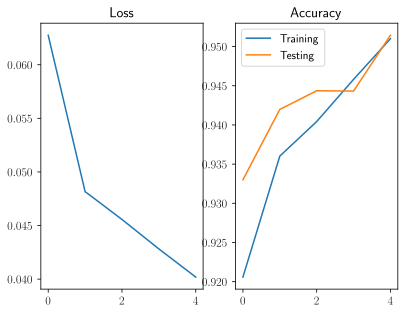

In [24]:
(epochs, losses, train_accs, test_accs) = train_model(model_z)
plt.subplot(1, 2, 1)
plt.plot(epochs, losses)
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Training")
plt.plot(epochs, test_accs, label="Testing")
plt.title("Accuracy")
plt.legend()

plt.show()

Epoch: 00 Loss: 0.0640 Training Acc: 0.9229 Testing Acc: 0.9415 Seconds elapsed: 43
Epoch: 01 Loss: 0.0503 Training Acc: 0.9385 Testing Acc: 0.9438 Seconds elapsed: 86
Epoch: 02 Loss: 0.0478 Training Acc: 0.9415 Testing Acc: 0.9353 Seconds elapsed: 131
Epoch: 03 Loss: 0.0464 Training Acc: 0.9427 Testing Acc: 0.9439 Seconds elapsed: 173
Epoch: 04 Loss: 0.0453 Training Acc: 0.9435 Testing Acc: 0.9437 Seconds elapsed: 218


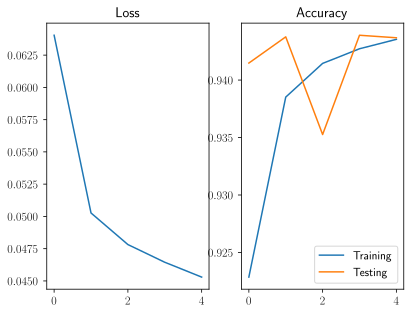

In [25]:
(epochs, losses, train_accs, test_accs) = train_model(model_x)
plt.subplot(1, 2, 1)
plt.plot(epochs, losses)
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Training")
plt.plot(epochs, test_accs, label="Testing")
plt.title("Accuracy")
plt.legend()

plt.show()

In [54]:

batches = 0
for batch in test_loader:
    x_preds = model_x.test_predictions(batch).detach().numpy()
    z_preds = model_z.test_predictions(batch).detach().numpy()
    
    total_preds = np.empty((x_preds.shape[0], 2))
    total_preds[:,0] = x_preds[:,0]
    total_preds[:,1] = z_preds[:,0]
    
    print(np.count_nonzero((total_preds == batch.y.numpy()).all(axis=1)))

887
902
902
900
901
918
916
891
909
899
900
880
916
912
893
902
910
905
898
891
903
893
909
904
897
915
896
904
917
909
892
899
887
898
906
887
898
905
900
904
886
889
908
908
890
920
901
891
903
903
